In [320]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from pandas.plotting import scatter_matrix
#import missingno as msno
from IPython.display import Markdown, display
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from datetime import date
from datetime import datetime

In [321]:
df = pd.read_csv('https://raw.githubusercontent.com/MarlaGoodman/CMS-Project/main/flights_model.csv')

In [322]:
df['response_var'] = np.where(df['dep_delay']> 0, 1, 0)

In [323]:
dummy_month = pd.get_dummies(df['month']).rename(columns=lambda x: 'Month_' + str(x))
dummy_hour = pd.get_dummies(df['hour']).rename(columns=lambda x: 'Hour_' + str(x))

In [324]:
df = pd.concat([df,dummy_month], axis=1)
df = pd.concat([df,dummy_hour], axis=1)

In [325]:
X = df['count_of_flight_by_day_carrier_origin']

In [326]:
X_manual_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [327]:
del df['count_of_flight_by_day_carrier_origin']

In [328]:
df = pd.concat([df,X_manual_scaled], axis=1)

In [329]:
X = df['count_delay_per_tail_number']

In [330]:
X_manual_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [331]:
del df['count_delay_per_tail_number']

In [332]:
df = pd.concat([df,X_manual_scaled], axis=1)

In [333]:
predictors = []

In [334]:
predictors.append('count_of_flight_by_day_carrier_origin')

In [335]:
dummy_list = list(dummy_month.columns)
dummy_list.extend(list(dummy_hour.columns))

In [336]:
predictors.extend(dummy_list)

In [337]:
predictors.remove('Hour_1')

In [338]:
predictors.append('rain_bool')

In [339]:
predictors.append('new_snow_bool')

In [340]:
predictors.append('count_delay_per_tail_number')

In [341]:
predictors

['count_of_flight_by_day_carrier_origin',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23',
 'rain_bool',
 'new_snow_bool',
 'count_delay_per_tail_number']

In [342]:
X = df[predictors]
y = df['response_var']

from sklearn.utils import shuffle
X, y = shuffle(X, y)

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

#Fitting Logistic Regression to the Training set with the first set of predictors.
classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

LogisticRegression()

In [343]:
#examine the model coefficients for the explanatory variables
#print(predictors)
#print(classifier1.coef_)

# Cross validation.
accuracy_list = []
recall_list = []
auc_list = []
f1_list = []
precision_list = []

# Metrics for testing set
recall_testing = []
f1_testing = []
precision_testing = []
acc_testing = []

accuracy = cross_val_score(classifier1, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(classifier1, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(classifier1, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(classifier1, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(classifier1, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

In [344]:
y_pred = classifier1.predict(X_test)
precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred)))
acc_testing.append(np.mean(metrics.accuracy_score(y_test,y_pred)))

In [345]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
#print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.609792
         Iterations 6


In [346]:
from sklearn.metrics import confusion_matrix
y_pred = classifier1.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[32964,  5751],
       [14419,  7616]], dtype=int64)

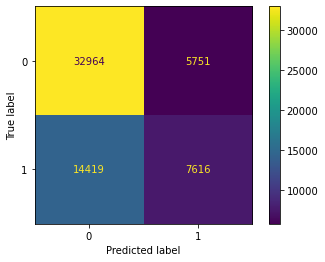

In [347]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [348]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#defining the scorer
f1_scorer = metrics.make_scorer(metrics.f1_score)
parameters = {'max_depth':np.arange(5,10),'class_weight':['balanced','none']}

In [349]:
# perform grid search to find best hyperparameters
#random_f = RandomForestClassifier()
#grid = GridSearchCV(random_f, parameters, scoring = f1_scorer, cv = 5, n_jobs = -1)
#grid.fit(X_train, y_train)
#model_est = grid.best_estimator_
#model_params = grid.best_params_
#grid.best_params_

In [350]:
# Random forest with my favourite state, state 42
rfc = RandomForestClassifier(random_state = 42, class_weight = 'balanced', max_depth = 6)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42)

In [351]:
# Storing in the results 
recall_list.append(np.mean(cross_val_score(rfc,  X_train, y_train, scoring = 'recall', cv = 5)))
f1_list.append(np.mean(cross_val_score(rfc,  X_train, y_train, scoring = 'f1', cv = 5)))
precision_list.append(np.mean(cross_val_score(rfc,  X_train, y_train, scoring = 'precision', cv = 5)))
accuracy_list.append(np.mean(cross_val_score(rfc,  X_train, y_train, scoring = 'accuracy', cv = 5)))
auc_list.append(np.mean(cross_val_score(rfc, X_train, y_train, scoring = "roc_auc", cv = 5)))

In [352]:
# on the testing set and store results
y_pred = rfc.predict(X_test)
#y_pred = rfc.predict_proba(X_test)[:,0]<.55
precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred)))
acc_testing.append(np.mean(metrics.accuracy_score(y_test,y_pred)))
confusion_matrix(y_test, y_pred)

array([[19927, 18788],
       [ 5485, 16550]], dtype=int64)

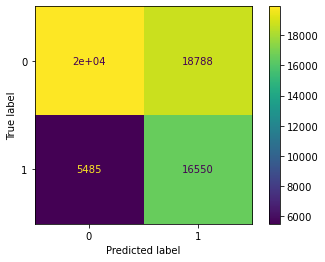

In [353]:
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [354]:
#np.where(df['dep_delay']> 0, 1, 0) 
#y_pred = rfc.predict_proba(X_test)[:,0]<.55 

In [355]:
y_pred = rfc.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

array([[26940, 11775],
       [ 9326, 12709]], dtype=int64)

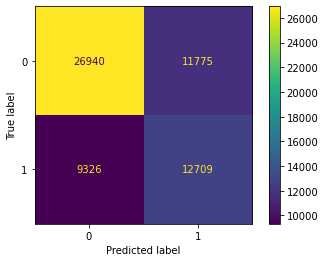

In [356]:
y_pred = rfc.predict_proba(X_test)[:,0]<.48 
#y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm

In [357]:
sum(df['response_var'])/df['response_var'].count()

0.3627085610440233

In [358]:
import xgboost as xgb

In [359]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [360]:
param = {
    'eta': 1, 
    'max_depth': 7,  
    'objective': 'multi:softprob',
#    'objective': 'binary:logistic',
    'num_class': 2} 

steps = 40  # The number of training iterations

In [361]:
model = xgb.train(param, D_train, steps)

[21:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [362]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
confusion_matrix(y_test, best_preds)

array([[32458,  6257],
       [12649,  9386]], dtype=int64)

In [363]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

precision_list.append(format(precision_score(y_test, best_preds, average='macro')))
recall_list.append(format(recall_score(y_test, best_preds, average='macro')))
accuracy_list.append(format(accuracy_score(y_test, best_preds)))
auc_list.append(format(roc_auc_score(y_test, best_preds)))
f1_list.append(format(f1_score(y_test, best_preds)))

precision_testing.append(np.mean(metrics.precision_score(y_test, best_preds)))
recall_testing.append(np.mean(metrics.recall_score(y_test, best_preds)))
f1_testing.append(np.mean(metrics.f1_score(y_test, best_preds)))
acc_testing.append(np.mean(metrics.accuracy_score(y_test,best_preds)))
confusion_matrix(y_test, best_preds)

array([[32458,  6257],
       [12649,  9386]], dtype=int64)

In [364]:
print("\t \t The Model Metric Matrix for the training set")
# Cross validation.
metrics_summary = pd.DataFrame()
metrics_summary['Model #'] = [ 'Log Regression', 'Random Forest Model ','XGB']
metrics_summary['Recall'] = recall_list
metrics_summary['Accuracy'] = accuracy_list
metrics_summary['Precision'] = precision_list
metrics_summary['AUC'] = auc_list
metrics_summary['F1_score'] = f1_list
metrics_summary1 = metrics_summary.copy()
metrics_summary1

	 	 The Model Metric Matrix for the training set


,Model #,Recall,Accuracy,Precision,AUC,F1_score
0,Log Regression,0.340311,0.665771,0.56519,0.676233,0.42482
1,Random Forest Model,0.741755,0.601075,0.468489,0.681348,0.574237
2,XGB,0.6321708788640382,0.6887901234567901,0.6597953389189657,0.6321708788640381,0.4982217739795106


In [365]:
confusion_matrix(y_test, best_preds)

array([[32458,  6257],
       [12649,  9386]], dtype=int64)

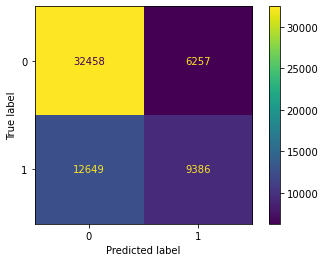

In [366]:
cm = confusion_matrix(y_test, best_preds)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [367]:
#precision_testing.append(format(precision_score(y_test, best_preds, average='macro')))
#recall_testing.append(format(recall_score(y_test, best_preds, average='macro')))
#acc_testing.append(format(accuracy_score(y_test, best_preds)))


print("\t \t The Model Metric Matrix for the testing set")
# Cross validation.
metrics_summary_test = pd.DataFrame()
metrics_summary_test['Model #'] = ['Logistic Regression','Random Forest Model ','XGB']
metrics_summary_test['Recall'] = recall_testing
metrics_summary_test['Accuracy'] = acc_testing
metrics_summary_test['Precision'] = precision_testing
#metrics_summary_test['AUC'] = auc_list
metrics_summary_test['F1_score'] = f1_testing
metrics_summary2 = metrics_summary_test.copy()
metrics_summary2

	 	 The Model Metric Matrix for the testing set


,Model #,Recall,Accuracy,Precision,F1_score
0,Logistic Regression,0.345632,0.667984,0.569761,0.430258
1,Random Forest Model,0.751078,0.600444,0.468334,0.576926
2,XGB,0.425959,0.688790,0.600013,0.498222


In [368]:
from sklearn.ensemble import  StackingClassifier

In [369]:
# define the 3 models as estimators for Stacking
#estimators = [('rfc', rfc),('xgb', model)]
estimators = [
                 ('rf_1', RandomForestClassifier(n_estimators=6, random_state=42)),
                 ('rf_2', LogisticRegression())             
                ]

In [370]:
ensemble = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
ensemble.fit(X_train, y_train)

StackingClassifier(estimators=[('rf_1',
                                RandomForestClassifier(n_estimators=6,
                                                       random_state=42)),
                               ('rf_2', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [371]:
recall_list.append(np.mean(cross_val_score(ensemble,  X_train, y_train, scoring = 'recall', cv = 5)))
f1_list.append(np.mean(cross_val_score(ensemble,  X_train, y_train, scoring = 'f1', cv = 5)))
precision_list.append(np.mean(cross_val_score(ensemble,  X_train, y_train, scoring = 'precision', cv = 5)))
accuracy_list.append(np.mean(cross_val_score(ensemble,  X_train, y_train, scoring = 'accuracy', cv = 5)))
auc_list.append(np.mean(cross_val_score(ensemble, X_train, y_train, scoring = "roc_auc", cv = 5)))

In [372]:
y_pred = ensemble.predict(X_test)
precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred)))
acc_testing.append(np.mean(metrics.accuracy_score(y_test,y_pred)))

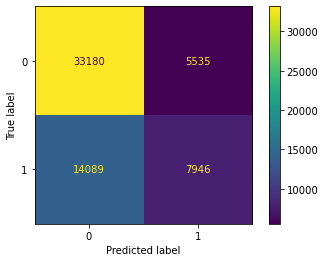

In [373]:
y_pred = ensemble.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [374]:


print("\t \t The Model Metric Matrix for the training set")
# Cross validation.
metrics_summary = pd.DataFrame()
metrics_summary['Model #'] = [ 'Log Regression', 'Random Forest Model ','XGB','ensemble']
metrics_summary['Recall'] = recall_list
metrics_summary['Accuracy'] = accuracy_list
metrics_summary['Precision'] = precision_list
metrics_summary['AUC'] = auc_list
metrics_summary['F1_score'] = f1_list
metrics_summary1 = metrics_summary.copy()
metrics_summary1

	 	 The Model Metric Matrix for the training set


,Model #,Recall,Accuracy,Precision,AUC,F1_score
0,Log Regression,0.340311,0.665771,0.56519,0.676233,0.42482
1,Random Forest Model,0.741755,0.601075,0.468489,0.681348,0.574237
2,XGB,0.6321708788640382,0.6887901234567901,0.6597953389189657,0.6321708788640381,0.4982217739795106
3,ensemble,0.357943,0.676187,0.588103,0.690495,0.445022


In [376]:
print("\t \t The Model Metric Matrix for the testing set")
# Cross validation.
metrics_summary_test = pd.DataFrame()
metrics_summary_test['Model #'] = ['Log','Random Forest Model ','XGB','ensemble']
metrics_summary_test['Recall'] = recall_testing
metrics_summary_test['Accuracy'] = acc_testing
metrics_summary_test['Precision'] = precision_testing
metrics_summary_test['F1_score'] = f1_testing
metrics_summary2 = metrics_summary_test.copy()
metrics_summary2

	 	 The Model Metric Matrix for the testing set


,Model #,Recall,Accuracy,Precision,F1_score
0,Log,0.345632,0.667984,0.569761,0.430258
1,Random Forest Model,0.751078,0.600444,0.468334,0.576926
2,XGB,0.425959,0.688790,0.600013,0.498222
3,ensemble,0.360608,0.676971,0.589422,0.447460
